# Identifying a subset of questionnaire questions to predict transdiagnostic factors

### Aim and approach

We wish to identify a subset of questions which can acccurately predict factor scores on the three transdiagnostic symptom dimensions identified by [Gillan et al (2016)](https://elifesciences.org/articles/11305), without having to ask all 209 questions. To do this, we train a multi-target lasso regression model on data from their Experiment 2 (n=1400), which can be found on [OSF](https://osf.io/usdgt/), using 5-fold cross validation to optimise the alpha hyperparameter, and find how many questions are needed to predict the factor scores with reasonably high accuracy.

The method and Python code here is adapted from (and broadly identical to) that used by [Wise & Dolan (2020)](https://www.nature.com/articles/s41467-020-17977-w), which was shared on [GitHub](https://github.com/tobywise/online-aversive-learning/blob/master/notebooks/questionnaire_analysis.ipynb). The only difference is that they used a different set of questionnaire data from [Rouault et al. (2018)](https://pubmed.ncbi.nlm.nih.gov/29458997/). While the same 209 questions were asked to a large online sample, it had less fine-grained Likert scoring for the Eating Attitudes Test (scored 0-3 vs 0-5) compared to the original study by [Gillan et al (2016)](https://elifesciences.org/articles/11305). This may have reduced the predictive accuracy of subsets of questions for the "compulsivity" factor.

### Setup

**Fix data paths, import dependencies, and import data**

In [6]:
# make sure correct Python interpreter selected in project options
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
import os, io, joblib, matplotlib, rpy2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm

matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'
pal = ['#4f4f4f', '#B80044', '#0e79b2']

os.chdir('C:/Users/qderc/Documents/Research Work/October 2021/pstpipeline')
%load_ext rpy2.ipython

buf = []
def f(x):
    buf.append(x)
rpy2.rinterface_lib.callbacks.consolewrite_print = f

qns = pd.read_csv('data/factor_prediction/gillan_qns.csv')
scores = pd.read_csv('data/factor_prediction/gillan_scores.csv')

### Fit model

**Hyperparameter optimisation**

Loop over candidate alpha values and record $R^2$ and number of items with non-zero coefficients following 5-fold cross-validation.

In [7]:
clf = Lasso()

alpha_values = [0.001, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
r2_values = np.empty((3, len(alpha_values)))
n_items = np.empty(len(alpha_values))

for n, alpha in enumerate(tqdm(alpha_values)):
    clf = Lasso(alpha=alpha)
    clf.fit(qns.iloc[:, 2:], scores.iloc[:, 2:]);
    pred = cross_val_predict(clf, qns.iloc[:, 2:], scores.iloc[:, 2:], cv=5)
    for i in range(3):
        r2_values[i, n] = r2_score(scores.iloc[:, i+2], pred[:, i])
    n_items[n] = np.any(clf.coef_.T != 0, axis=1).sum()


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


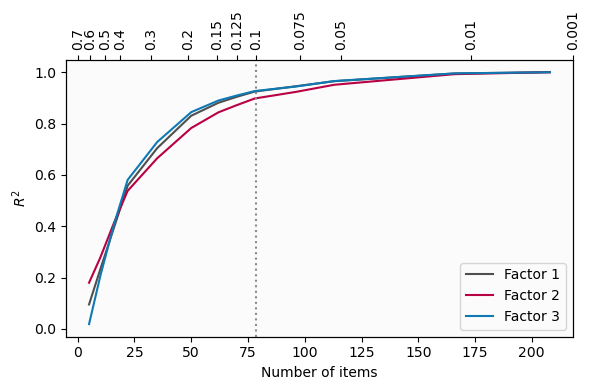

In [13]:
f, ax = plt.subplots(dpi=100, facecolor='white')
for i in range(3):
    ax.plot(n_items, r2_values[i, :], label='Factor {0}'.format(i+1), color=pal[i])
ax.set_xlabel("Number of items")
ax.set_ylabel("$R^2$")
ax.legend()
ax2 = ax.twiny()
ax2.set_xticks(n_items)
ax2.set_xticklabels(alpha_values)
ax2.axvline(78, color='#8c8a8a', linestyle=':')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
# plt.savefig("notebooks/plots/R2_plot.png");

An alpha value of 0.1 looks like it gives a good balance between accurate predictions and a number of questions.

**Predict factor scores and identify question subset**

Using alpha=0.1 and 5-fold CV:

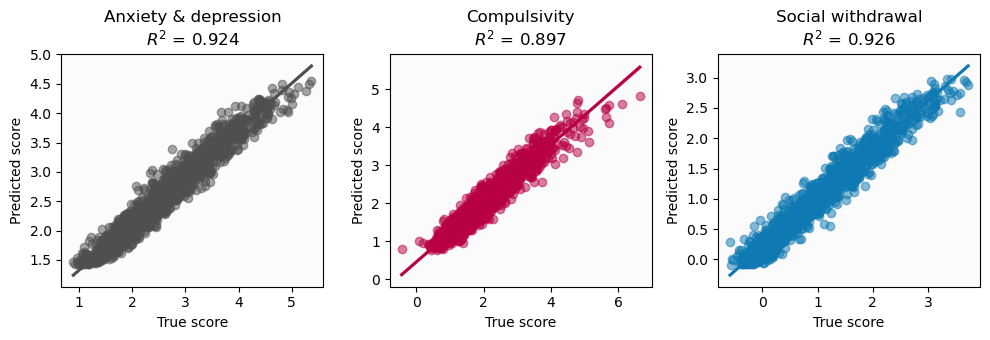

In [16]:
clf = Lasso(alpha=0.1)
pred = cross_val_predict(clf, qns.iloc[:, 2:], scores.iloc[:, 2:], cv=5)

clf.fit(qns.iloc[:, 2:], scores.iloc[:, 2:]);

f, ax = plt.subplots(1, 3, figsize=(10, 3.5), dpi=100, facecolor='white')

factors = ['Anxiety & depression', 'Compulsivity', 'Social withdrawal']

for i in range(3):
    sns.regplot(x=scores.iloc[:, i+2], y=pred[:, i], ax=ax[i], color=pal[i], scatter_kws={'alpha': 0.5});
    ax[i].set_title(factors[i] + '\n$R^2$ = {0}'.format(np.round(r2_score(scores.iloc[:, i+2], pred[:, i]), 3)), fontweight='light');
    ax[i].set_xlabel('True score');
    ax[i].set_ylabel('Predicted score');

plt.tight_layout()
# plt.savefig('notebooks/plots/alpha01_gillan.png')

This indeed seems to do a good job of predicting true factor scores, including for compulsivity.

In [17]:
np.any(clf.coef_.T != 0, axis=1).sum()

78

We have 78 questions included (as the weights for all other coefficients have been fixed to 0). These appear to be fairly specific to the factors (i.e., few questions have weights > 0 for more than 1 factor).

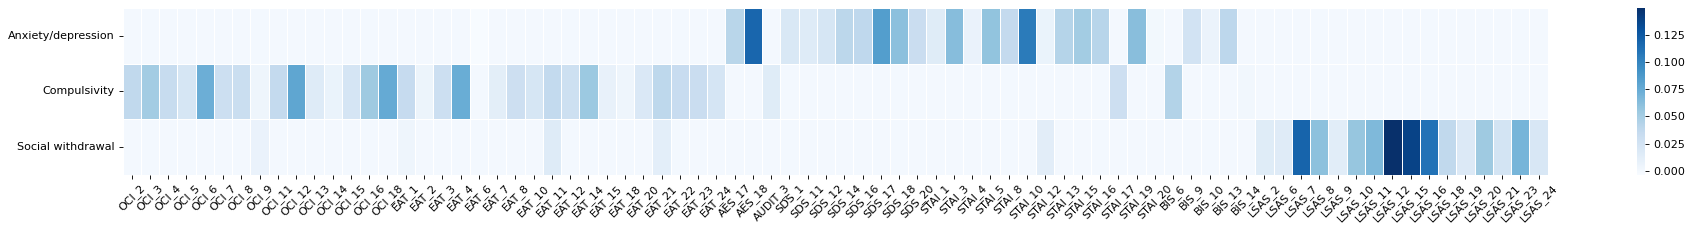

In [19]:
plt.figure(figsize=(24, 3), dpi=80, facecolor='white');
coefs = clf.coef_.T
sns.heatmap(coefs[np.any(coefs != 0, axis=1)].T, cmap="Blues", xticklabels=qns.columns[2:][np.any(coefs != 0, axis=1)],
          yticklabels=['Anxiety/depression', 'Compulsivity', 'Social withdrawal'], linewidths=.5);
plt.xticks(rotation=45);
plt.tight_layout()
plt.savefig('notebooks/plots/question_subset_heatmap.png')

In [21]:
# save classifier
joblib.dump(clf, 'data/factor_prediction/gillan_classifier_78.pkl')

# save item weights
weight_df = pd.DataFrame(coefs, columns=['Anxiety/depression', 'Compulsivity', 'Social withdrawal'], index=np.arange(coefs.shape[0]))
weight_df['item'] = qns.columns[2:]
weight_df.to_csv('data/factor_prediction/gillan_classifier_weights_78.csv', index=None)

# save list of questions
reduced_qns = (qns.iloc[:,2:]).iloc[:, np.any(clf.coef_.T != 0, axis=1)]
reduced_qns.to_csv('data/factor_prediction/reduced_qns_gillan_78.csv')